In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from dyt import DYT
from rmsnorm import TritonRMSNorm

In [2]:
dtype = torch.bfloat16
device = 'cuda'
bs, seq_len, dim = 1, 2048, 4096
x1 = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)
dyt1 = DYT(dim).to(device).to(dtype)
dyt1.gemma.data.copy_(torch.randn(dim))
dyt1.beta.data.copy_(torch.randn(dim))
dyt2 = deepcopy(dyt1)


In [3]:
y1 = dyt1(x1, "torch")
y2 = dyt2(x2, "triton")
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print((dyt1.gemma.grad-dyt2.gemma.grad).abs().max(), (dyt1.gemma.grad-dyt2.gemma.grad).abs().mean())
print((dyt1.beta.grad-dyt2.beta.grad).abs().max(), (dyt1.beta.grad-dyt2.beta.grad).abs().mean())
print((dyt1.alpha.grad-dyt2.alpha.grad).abs() / dyt1.alpha.grad.abs())


tensor(0.0312, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0007, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0312, device='cuda:0', dtype=torch.bfloat16) tensor(0.0005, device='cuda:0', dtype=torch.bfloat16)
tensor(0.2500, device='cuda:0', dtype=torch.bfloat16) tensor(0.0339, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor([0.0162], device='cuda:0', dtype=torch.bfloat16)


bs: 8, seq_len: 1024


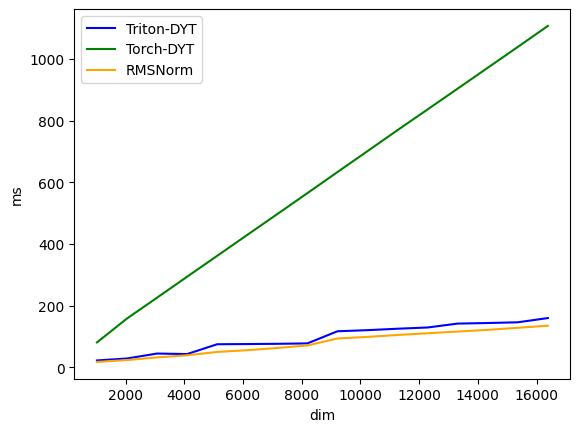

forward:
        dim  Triton-DYT    Torch-DYT     RMSNorm
0    1024.0   22.511998    80.947846   17.730890
1    2048.0   28.854247   158.520803   23.827033
2    3072.0   44.880453   226.074010   32.454561
3    4096.0   43.203622   293.957740   39.145142
4    5120.0   75.035013   361.713856   50.168678
5    6144.0   75.662635   429.439843   55.814158
6    7168.0   76.443806   497.049510   62.944524
7    8192.0   77.771284   564.859807   71.185365
8    9216.0  117.058143   633.172810   93.664952
9   10240.0  120.713823   701.049149   98.916247
10  11264.0  125.366509   769.188643  105.042629
11  12288.0  129.374862   836.281180  110.618331
12  13312.0  141.995281   903.777659  116.163105
13  14336.0  143.863037   971.329927  121.622548
14  15360.0  146.188736  1038.801312  128.407642
15  16384.0  159.880728  1106.947541  135.238141


In [4]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'triton'))
    if provider == 'Torch-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'torch'))
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: norm(tensor))
    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 8, seq_len: 1024


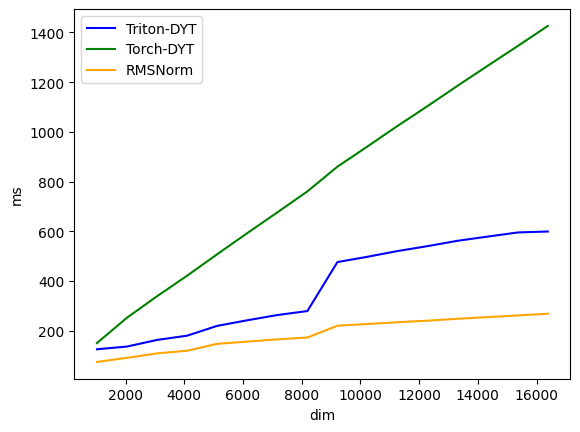

backward:
        dim  Triton-DYT    Torch-DYT     RMSNorm
0    1024.0  125.130355   150.048941   74.173547
1    2048.0  136.014521   252.166539   90.561822
2    3072.0  162.666067   338.546127  108.548217
3    4096.0  179.800719   421.211571  119.167820
4    5120.0  219.276845   507.549345  147.063091
5    6144.0  241.730139   592.424333  155.868471
6    7168.0  262.799293   675.949156  165.091783
7    8192.0  278.873086   760.404646  172.378942
8    9216.0  476.017356   859.925926  219.810024
9   10240.0  497.311354   941.231012  226.908848
10  11264.0  520.327926  1023.946047  233.854994
11  12288.0  540.233195  1103.730321  240.275264
12  13312.0  561.693072  1185.870171  247.826636
13  14336.0  578.614712  1266.004682  254.595786
14  15360.0  595.213234  1345.621705  261.228621
15  16384.0  598.984063  1426.330566  268.214524


In [3]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    dy = torch.rand_like(tensor)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        y = dyt(tensor, 'triton')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Torch-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        y = dyt(tensor, 'torch')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        y = norm(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
